In [1]:
import numpy as np
import networkx as nx
import os
from random import shuffle          # importamos las librerias necesarias
import matplotlib.pylab as plt       
%matplotlib inline
from matplotlib.pyplot import title,xlabel,ylabel,show

In [2]:
G = nx.read_gml('dolphins.gml') # definimos la red:cada nodo es un delfin y cada conexion representa una interaccion

In [3]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

dolphinsGender=ldata('dolphinsGender.txt') # usamos la funcion "ldata" para abrir el archivo .txt 

In [4]:
dict_gender = {dolphin_nombre : genero for dolphin_nombre, genero  in dolphinsGender}
for n in G.nodes:
    G.nodes[n]["gender"] = dict_gender[n] 

# PARTICION EN CLUSTERS

In [5]:
import igraph as igraph
import networkx as nx
import community
import time

In [6]:
def calculate_info_fast(np_adj_list, method):
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    t0=time.time()
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership

    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
                     
    return labels

In [7]:
def AssingCommunities(G,comunidades,name_coms): #comunidades=lista de diccionarios de comunidades
    for name in name_coms:
        for n in G.nodes():
            G.nodes[n][name]=comunidades[0][n]

In [8]:
def Communities(G,labels,name_coms): #laabels=lista de labels de comunidades
    Communities=[]
    for k in range(len(labels)):
        nodos_por_comunidad=[]
        for i in range(len(set(labels[k]))):
            nodos=[]
            for nodo in G.nodes():
                if i==nx.get_node_attributes(G,name_coms[k])[nodo]:
                    nodos.append(nodo)
            nodos_por_comunidad.append(nodos)
        Communities.append(nodos_por_comunidad)
    return(Communities)

COMUNIDADES CON TODOS LOS CRITERIOS

In [9]:
def all_communities(G):
    
    A=nx.to_numpy_matrix(G)
    
    labels_infomap=calculate_info_fast(A,method='infomap')
    global dict_comun_infomap
    dict_comun_infomap=dict(zip(list(G.nodes()),labels_infomap))
    
    comunidades=[dict_comun_infomap]
    
    global name_coms
    name_coms=['comunidad_infomap']
    
    AssingCommunities(G,comunidades,name_coms)
    
    global labels
    labels=[labels_infomap]
    
    all_coms=Communities(G,labels,name_coms)
    
    return all_coms

In [10]:
comunidades_infomap=all_communities(G)

# PARA ROMI

In [11]:
dict_comun_infomap

{'Beak': 4,
 'Beescratch': 3,
 'Bumper': 4,
 'CCL': 5,
 'Cross': 2,
 'DN16': 1,
 'DN21': 1,
 'DN63': 3,
 'Double': 5,
 'Feather': 1,
 'Fish': 4,
 'Five': 2,
 'Fork': 0,
 'Gallatin': 1,
 'Grin': 0,
 'Haecksel': 2,
 'Hook': 0,
 'Jet': 1,
 'Jonah': 2,
 'Knit': 3,
 'Kringel': 0,
 'MN105': 2,
 'MN23': 1,
 'MN60': 2,
 'MN83': 2,
 'Mus': 3,
 'Notch': 3,
 'Number1': 3,
 'Oscar': 3,
 'PL': 3,
 'Patchback': 2,
 'Quasi': 1,
 'Ripplefluke': 1,
 'SMN5': 2,
 'SN100': 5,
 'SN4': 0,
 'SN63': 0,
 'SN89': 5,
 'SN9': 0,
 'SN90': 1,
 'SN96': 4,
 'Scabs': 0,
 'Shmuddel': 0,
 'Stripes': 0,
 'TR120': 0,
 'TR77': 4,
 'TR82': 1,
 'TR88': 0,
 'TR99': 0,
 'TSN103': 0,
 'TSN83': 0,
 'Thumper': 0,
 'Topless': 2,
 'Trigger': 2,
 'Upbang': 1,
 'Vau': 2,
 'Wave': 1,
 'Web': 1,
 'Whitetip': 0,
 'Zap': 5,
 'Zig': 1,
 'Zipfel': 0}

PLOT

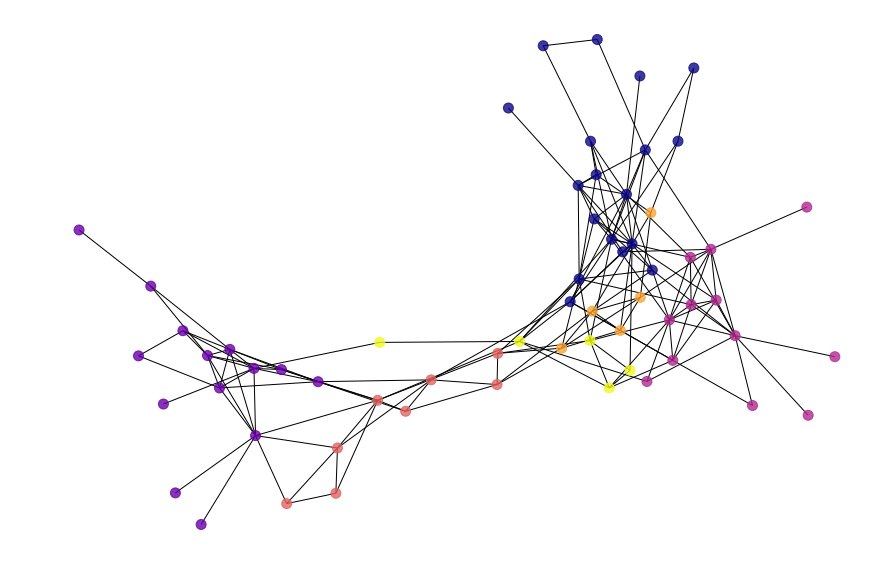

In [12]:
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G) 
        
nx.draw_networkx_nodes(G,pos,
                       cmap=plt.get_cmap('plasma'),
                       node_color=list(dict(nx.get_node_attributes(G,name_coms[0])).values()),
                       node_size=100,
                       alpha=0.8,with_labels=True)

#width = 1+10*np.array(list(networkx.get_edge_attributes(g,'weight').values())).ravel()
#edge_color = np.random.uniform(size=len(width))

nx.draw_networkx_edges(G,pos)#"grey")
#plt.title("A bizarre graph")
plt.axis("off")
plt.show()

MODULARITY

In [13]:
from __future__ import division

from functools import wraps
from itertools import product

import networkx as nx
from networkx import NetworkXError
from networkx.utils import not_implemented_for
from networkx.algorithms.community.community_utils import is_partition

__all__ = ['coverage', 'modularity', 'performance']

class NotAPartition(NetworkXError):
    """Raised if a given collection is not a partition.

    """

    def __init__(self, G, collection):
        msg = '{} is not a valid partition of the graph {}'
        msg = msg.format(G, collection)
        super(NotAPartition, self).__init__(msg)


def modularity(G, communities, weight='weight'):
    
    if not is_partition(G, communities):
        raise NotAPartition(G, communities)

    multigraph = G.is_multigraph()
    directed = G.is_directed()
    m = G.size(weight=weight)
    if directed:
        out_degree = dict(G.out_degree(weight=weight))
        in_degree = dict(G.in_degree(weight=weight))
        norm = 1 / m
    else:
        out_degree = dict(G.degree(weight=weight))
        in_degree = out_degree
        norm = 1 / (2 * m)

    def val(u, v):
        try:
            if multigraph:
                w = sum(d.get(weight, 1) for k, d in G[u][v].items())
            else:
                w = G[u][v].get(weight, 1)
        except KeyError:
            w = 0
        # Double count self-loops if the graph is undirected.
        if u == v and not directed:
            w *= 2
        return w - in_degree[u] * out_degree[v] * norm

    Q = sum(val(u, v) for c in communities for u, v in product(c, repeat=2))
    return Q * norm

In [14]:
mod_infomap=modularity(G,comunidades_infomap[0])
mod_infomap

0.5189470353229688

SILLOUETTE

In [15]:
def silhouette(G,comunidades_infomap):
    a=[]

    for nodo1 in list(G.nodes()):
        Ncom_a=G.nodes('comunidad_infomap')[nodo1] #numero con el que se etiqueta la comunidad
        comunidad_nodo=comunidades_infomap[0][Ncom_a] # lista con los nodos de esa comunidad
        dist=[]
        for nodo2 in comunidad_nodo:   
            if not nodo1==nodo2:
                dist.append(nx.shortest_path_length(G,source=nodo1,target=nodo2))
        a.append(np.mean(np.array(dist)))
        
    b=[]    
        
    Ncom=len(comunidades_infomap[0]) # si no es mayor a 1 sonamos
    
    if Ncom==1:
        silhouette=0
    else:
        list_Ncom=[]
        for i in range(Ncom):
            list_Ncom.append(i)

        for nodo1 in list(G.nodes()):
            list_Ncomunidades=[]
            list_Ncomunidades=list_Ncom.copy()
            Ncom_b=G.nodes('comunidad_infomap')[nodo1]
            list_Ncomunidades.remove(Ncom_b)

            pre_b=[]
            for Ncomunidad in (list_Ncomunidades):
                comunidad_nodo2=comunidades_infomap[0][Ncomunidad]
                distb=[]
                for nodo2 in comunidad_nodo2:
                    distb.append(nx.shortest_path_length(G,source=nodo1,target=nodo2))
                pre_b.append(np.mean(np.array(distb)))
                
            b.append(np.array(pre_b).min())

        max_ab=np.array(max(a,b))
        a=np.array(a)
        b=np.array(b)
        s=(b-a)/max_ab
        silhouette=np.mean(s)
    return silhouette

In [16]:
sil_infomap=silhouette(G,comunidades_infomap)
sil_infomap

0.23532242495935768

In [17]:
comunidades_infomap

[[['Fork',
   'Grin',
   'Hook',
   'Kringel',
   'Scabs',
   'Shmuddel',
   'SN4',
   'SN63',
   'SN9',
   'Stripes',
   'Thumper',
   'TR120',
   'TR88',
   'TR99',
   'TSN103',
   'TSN83',
   'Whitetip',
   'Zipfel'],
  ['DN16',
   'DN21',
   'Feather',
   'Gallatin',
   'Jet',
   'MN23',
   'Quasi',
   'Ripplefluke',
   'SN90',
   'TR82',
   'Upbang',
   'Wave',
   'Web',
   'Zig'],
  ['Cross',
   'Five',
   'Haecksel',
   'Jonah',
   'MN105',
   'MN60',
   'MN83',
   'Patchback',
   'SMN5',
   'Topless',
   'Trigger',
   'Vau'],
  ['Beescratch', 'DN63', 'Knit', 'Mus', 'Notch', 'Number1', 'Oscar', 'PL'],
  ['Beak', 'Bumper', 'Fish', 'SN96', 'TR77'],
  ['CCL', 'Double', 'SN100', 'SN89', 'Zap']]]

# AHORA VIENE LO BUENO(?)

In [18]:
DistributionModularity = []                          # Vector para guardar las modularidades de cada iteracion
DistributionSilhouette= []

it =1000 # numero de iteraciones 
Grafo = G.copy()                      

for i in range(it):
    #Generar grafo recableado
    list_degrees=list(dict(Grafo.degree).values())
    GR=nx.configuration_model(list_degrees,create_using=nx.Graph)
    
    #Calcular los clusters usando TODOS los criterios
    comunidades_GR=all_communities(GR)
    #Calcular Mod y Silhouette
    DistributionModularity.append(modularity(GR,comunidades_GR[0]))
    
    #Me quedo solo con los grafos en los cuales todas las componentes estan conectadas porque
    #si no me genera problemas con el shortest_path_length
    giant = max(nx.connected_component_subgraphs(GR), key=len)
    if len(giant.nodes())==62:
        DistributionSilhouette.append(silhouette(GR,comunidades_GR))

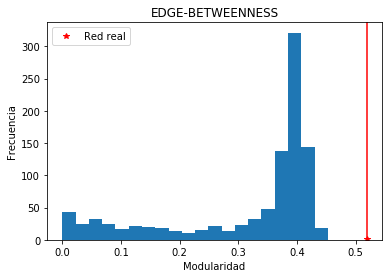

In [19]:
DM=np.array(DistributionModularity)
plt.hist(DM,bins=20)
plt.plot(mod_infomap,1,'*',c='r',label='Red real')
plt.axvline(mod_infomap,c='r')
plt.xlabel('Modularidad')
plt.ylabel('Frecuencia')
plt.title('EDGE-BETWEENNESS')
plt.legend()

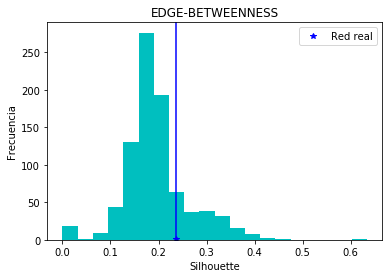

In [20]:
DS=np.array(DistributionSilhouette)
plt.hist(DS,bins=20,color='c')
plt.plot(sil_infomap,1,'*',c='b',label='Red real')
plt.axvline(sil_infomap,c='b')
plt.xlabel('Silhouette')
plt.ylabel('Frecuencia')
plt.title('EDGE-BETWEENNESS')
plt.legend()